In [10]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mp
import sklearn
from IPython.display import Image, HTML
import statsmodels.api as sm
from sklearn import model_selection
from sklearn import metrics

import laUtilities as ut

%matplotlib inline

from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.formula.api as smf

np.random.seed(9876789)

# More on Linear Regression

Today, we'll look at some additional aspects of Linear Regression.

Our first topic is multicollinearity.

## Multicollinearity

To illustrate the multcollinearity problem, we'll load a standard dataset.

The Longley dataset contains various US macroeconomic variables from 1947–1962.

These variables are known to be highly collinear. 

```{note}
A good reference for the following is 
https://www.sjsu.edu/faculty/guangliang.chen/Math261a/Ch9slides-multicollinearity.pdf
```

In [23]:
from statsmodels.datasets.longley import load_pandas
y = load_pandas().endog
X = load_pandas().exog
X['const'] = 1.0
X.index = X['YEAR']
y.index = X['YEAR']
X.drop('YEAR', axis = 1, inplace = True)
X

,GNPDEFL,GNP,UNEMP,ARMED,POP,const
YEAR,,,,,,
1947.0,83.0,234289.0,2356.0,1590.0,107608.0,1.0
1948.0,88.5,259426.0,2325.0,1456.0,108632.0,1.0
1949.0,88.2,258054.0,3682.0,1616.0,109773.0,1.0
1950.0,89.5,284599.0,3351.0,1650.0,110929.0,1.0
1951.0,96.2,328975.0,2099.0,3099.0,112075.0,1.0
1952.0,98.1,346999.0,1932.0,3594.0,113270.0,1.0
1953.0,99.0,365385.0,1870.0,3547.0,115094.0,1.0
1954.0,100.0,363112.0,3578.0,3350.0,116219.0,1.0
1955.0,101.2,397469.0,2904.0,3048.0,117388.0,1.0


In [24]:
ols_model = sm.OLS(y, X)
ols_results = ols_model.fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     156.4
Date:                Mon, 01 Nov 2021   Prob (F-statistic):           3.70e-09
Time:                        14:57:59   Log-Likelihood:                -117.83
No. Observations:                  16   AIC:                             247.7
Df Residuals:                      10   BIC:                             252.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
GNPDEFL      -48.4628    132.248     -0.366      0.7

/Users/crovella/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


What does this mean?

>In statistics, multicollinearity (also collinearity) is a phenomenon in which two or more predictor variables in a multiple regression model are highly correlated, meaning that one can be linearly predicted from the others with a substantial degree of accuracy.

(Wikipedia)

The condition number being referred to is the condition number of the design matrix.

That is the $X$ in $X\beta = y$. 

Remember that to solve a least-squares problem $X\beta = y$, we solve the normal equations

$$X^TX\beta = X^Ty.$$

These equations always have at least one solution.

However, the "at least one" part is problematic!

If there are multiple solutions, they are in a sense all equivalent in that they yield the same value of $\Vert X\beta - y\Vert$.

However, the actual values of $\beta$ can vary tremendously and so it is not clear how best to interpret the case when $X$ does not have full column rank.

When does this problem occur?   Look at the normal equations:

$$X^TX\beta = X^Ty.$$

It occurs when $X^TX$ is __not invertible.__

In that case, we cannot simply solve the normal equations by computing $\hat{\beta} = (X^TX)^{-1}X^Ty.$

When is $(X^TX)$ not invertible?

A matrix is not invertible iff at least one of its eigenvalues is zero.

This happens when the columns of $X$ are not linearly independent, ie, one column can be expressed as a linear combination of the other columns.

One obvious case is if $X$ has more columns than rows.   That is, if there are more _variables_ than _equations_.

This case is easy to recognize. 

However, a more insidious case occurs when the columns of $X$ happen to be linearly dependent because of the nature of the data itself.

This happens when one column is a linear function of the other columns.   Ie, one independent variable is a linear function of one or more of the others.

Unfortunately, in practice we will run into trouble even if variables are __almost__ linearly dependent. 

This presents problems because measurements are not exact, and small errors are magnified when computing $(X^TX)^{-1}$. 

So, more simply, when two or more columns are __strongly correlated__, we will have problems with linear regression.

This is called __multicollinearity__ in the terminology of statistics.

Condition number is a measure of whether $X$ is __nearly__ lacking full column rank.

In other words, whether some column is __close to__ being a linear combination of the other columns.

Even in this case, the actual values of $\beta$ can vary a lot due to the limitations of numerical precision in the computer.

Recall that $X^TX$ will not be invertible if it has at least one zero eigenvalue.   

Condition number relaxes this -- it asks if $X^TX$ has a __very small__ eigenvalue (compared to its largest eigenvalue).

An easy way to assess this is using the SVD of $X$.

(Thank you, "swiss army knife"!)

The eigenvalues of $X^TX$ are the squares of the singular values of $X$.   

So the condition number of $X$ is defined as:

$$\kappa(X) = \frac{\sigma_{\mbox{max}}}{\sigma_{\mbox{min}}}$$

where $\sigma_{\mbox{max}}$ and $\sigma_{\mbox{min}}$ are the largest and smallest singular values of $X$.

A large condition number -- is a problem.   

* If the condition number is less than 100, there is no serious problem
with multicollinearity.
* Condition numbers between 100 and 1000 imply moderate to strong multicollinearity.
* Condition numbers bigger than 1000 indicate severe multicollinearity.

Let's look at pairwise scatterplots of our data:

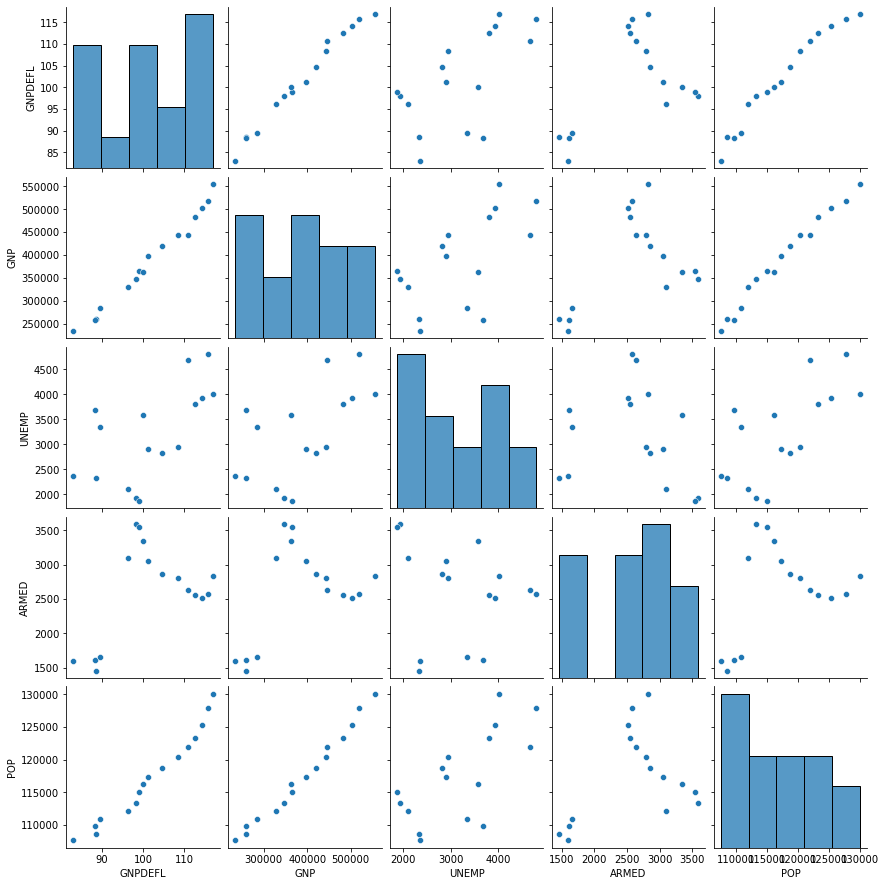

In [29]:
sns.pairplot(X[['GNPDEFL', 'GNP', 'UNEMP', 'ARMED', 'POP']]);

We can see __very__ strong linear relationships between, eg, __GNP Deflator__, __GNP__, and __Population.__

This does not happen too often in practice, but there are some things that can be done if it does happen:

(1) We can __regularize__ the regression.   This consists of adding a penalty term to the regression:

$$ \hat{\beta} = \arg \min \Vert X\beta - y \Vert + \lambda \Vert\beta\Vert.$$

This goes by the term __ridge regression__ (or __Tikhanov regularization__).

The idea here is (basically): there may be many solutions that are (approximately) consistent with the equations.   However erroneous solutions tend to have large values (which are used to create cancellations among the columns).   We want to avoid those solutions.

(2) We can try to find one of the offending predictor variables, and leave it out of the regression.

This goes by the term __variable elimination__ or __feature selection__ (which you can investigate as needed).

## Influence

Also, it can happen that dropping a single observation can have a dramatic effect on the coefficient estimates.

Restricting ourselves to the first 14 observations:

In [9]:
ols_results2 = sm.OLS(y.ix[:14], X.ix[:14]).fit()

Let us see how much each parameter changes if we compare to all 16 observations:

In [10]:
print("Percentage change %4.2f%%\n"*7 % tuple([i for i in (ols_results2.params - ols_results.params)/ols_results.params*100]))

Percentage change -13.35%
Percentage change -236.18%
Percentage change -23.69%
Percentage change -3.36%
Percentage change -7.26%
Percentage change -200.46%
Percentage change -13.34%



Formal statistics for this such as the DFBETAS -- a standardized measure of how much each coefficient changes when that observation is left out.

An observation is considered troublesome if its DFBETA is greater than $2/\sqrt{\text{number of observations}}$.

In [11]:
infl = ols_results.get_influence()
## significant influence
2./len(X)**.5

0.5

In [12]:
print(infl.summary_frame().filter(regex="dfb"))

    dfb_const  dfb_GNPDEFL   dfb_GNP  dfb_UNEMP  dfb_ARMED   dfb_POP  dfb_YEAR
0   -0.016406    -0.234566 -0.045095  -0.121513  -0.149026  0.211057  0.013388
1   -0.020608    -0.289091  0.124453   0.156964   0.287700 -0.161890  0.025958
2   -0.008382     0.007161 -0.016799   0.009575   0.002227  0.014871  0.008103
3    0.018093     0.907968 -0.500022  -0.495996   0.089996  0.711142 -0.040056
4    1.871260    -0.219351  1.611418   1.561520   1.169337 -1.081513 -1.864186
5   -0.321373    -0.077045 -0.198129  -0.192961  -0.430626  0.079916  0.323275
6    0.315945    -0.241983  0.438146   0.471797  -0.019546 -0.448515 -0.307517
7    0.015816    -0.002742  0.018591   0.005064  -0.031320 -0.015823 -0.015583
8   -0.004019    -0.045687  0.023708   0.018125   0.013683 -0.034770  0.005116
9   -1.018242    -0.282131 -0.412621  -0.663904  -0.715020 -0.229501  1.035723
10   0.030947    -0.024781  0.029480   0.035361   0.034508 -0.014194 -0.030805
11   0.005987    -0.079727  0.030276  -0.008883  -0.

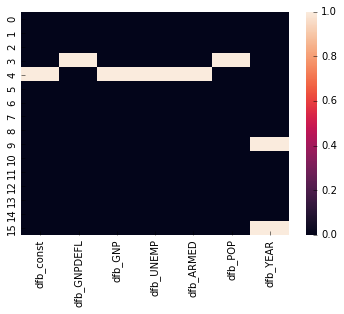

In [13]:
sns.heatmap(infl.summary_frame().filter(regex="dfb") > 0.5 )

## Flexible Modeling

The Guerry dataset is a collection of historical data used in support of Andre-Michel Guerry’s 1833 "Essay on the Moral Statistics of France."

>Andre-Michel Guerry’s (1833) Essai sur la Statistique Morale
de la France was one of the foundation studies of modern social science.
Guerry assembled data on crimes, suicides, literacy and other “moral
statistics,” and used tables and maps to analyze a variety of social issues
in perhaps the first comprehensive study relating such variables.

Wikipedia

>Guerry’s results were startling for two reasons.
First he showed that rates of crime and suicide remained
remarkably stable over time, when broken
down by age, sex, region of France and even season
of the year; yet these numbers varied systematically
across departements of France. This regularity
of social numbers created the possibility to
conceive, for the first time, that human actions in
the social world were governed by social laws, just
as inanimate objects were governed by laws of the
physical world.

Source: "A.-M. Guerry’s Moral Statistics of France: Challenges for Multivariable
Spatial Analysis", Michael Friendly.  Statistical Science 2007, Vol. 22, No. 3, 368–399.

In [14]:
# Lottery is per-capital wager on Royal Lottery
df = sm.datasets.get_rdataset("Guerry", "HistData").data
df = df[['Lottery', 'Literacy', 'Wealth', 'Region']].dropna()
df.head()

,Lottery,Literacy,Wealth,Region
0,41,37,73,E
1,38,51,22,N
2,66,13,61,C
3,80,46,76,E
4,79,69,83,E


We can use another version of the module that can directly type formulas and expressions in the functions of the models.


We can specify the name of the columns to be used to predict another column, remove columns, etc.

In [15]:
mod = smf.ols(formula='Lottery ~ Literacy + Wealth + Region', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     6.636
Date:                Tue, 14 Nov 2017   Prob (F-statistic):           1.07e-05
Time:                        10:52:35   Log-Likelihood:                -375.30
No. Observations:                  85   AIC:                             764.6
Df Residuals:                      78   BIC:                             781.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      38.6517      9.456      4.087      

__Categorical variables__

Patsy is the name of the interpreter that parses the formulas.

Looking at the summary printed above, notice that patsy determined that elements of Region were text strings, so it treated Region as a categorical variable. 

Patsy‘s default is also to include an intercept, so we automatically dropped one of the Region categories.

__Removing variables__

The “-” sign can be used to remove columns/variables. For instance, we can remove the intercept from a model by:

In [16]:
res = smf.ols(formula='Lottery ~ Literacy + Wealth + C(Region) -1 ', data=df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     6.636
Date:                Tue, 14 Nov 2017   Prob (F-statistic):           1.07e-05
Time:                        10:52:35   Log-Likelihood:                -375.30
No. Observations:                  85   AIC:                             764.6
Df Residuals:                      78   BIC:                             781.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
C(Region)[C]    38.6517      9.456      4.087   

__Functions__

We can also apply vectorized functions to the variables in our model:

In [17]:
res = smf.ols(formula='Lottery ~ np.log(Literacy)', data=df).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     15.89
Date:                Tue, 14 Nov 2017   Prob (F-statistic):           0.000144
Time:                        10:52:35   Log-Likelihood:                -385.38
No. Observations:                  85   AIC:                             774.8
Df Residuals:                      83   BIC:                             779.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept          115.6091     18.374  

## Understanding Problematic Observations

In [18]:
from statsmodels.formula.api import ols
from statsmodels.compat import lzip
prestige = sm.datasets.get_rdataset("Duncan", "car", cache=True).data


This is data on the
"prestige" and other characteristics of 45 U. S. occupations in 1950.

* type: Type of occupation. A factor with the following levels: ``prof``,
    professional and managerial; ``wc``, white-collar; ``bc``,
    blue-collar.
* income: Percent of males in occupation earning USD 3500 or more in 1950.
* education: Percent of males in occupation in 1950 who were high-school graduates.
* prestige: Percent of raters in NORC study rating occupation as excellent or good in prestige.

In [19]:
prestige.head()

,type,income,education,prestige
accountant,prof,62,86,82
pilot,prof,72,76,83
architect,prof,75,92,90
author,prof,55,90,76
chemist,prof,64,86,90


In [20]:
prestige_model = ols("prestige ~ income + education", data=prestige).fit()
print(prestige_model.summary())

                            OLS Regression Results                            
Dep. Variable:               prestige   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     101.2
Date:                Tue, 14 Nov 2017   Prob (F-statistic):           8.65e-17
Time:                        10:52:36   Log-Likelihood:                -178.98
No. Observations:                  45   AIC:                             364.0
Df Residuals:                      42   BIC:                             369.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -6.0647      4.272     -1.420      0.1

__Influence plots__

To ask about the impact of individual observations on the overall model, we can calculate the `influence` of each observation.

`leverage` is a measure of how far away the independent variable values of an observation are from those of the other observations.

The `residual` is the error obtained when predicting the observation.

Influence plots show the studentized residuals vs. the leverage of each observation as measured by the projection matrix.

Externally studentized residuals are residuals that are scaled by their standard deviation where
$$\text{var}(\hat{\epsilon}_i)=\hat{\sigma}^2(1-h_{ii}).$$
 $h_{ii}$ is the $i$-th diagonal element of the projection matrix
$$H=X(X^TX)^{-1}X^T$$
where $X$ is the design matrix.

It can be shown that $$h_{ii} = \frac{\partial\hat{y}_i}{\partial y_i}.$$

The influence of each point can be visualized by the criterion keyword argument. Options are Cook's distance and DFFITS, two measures of influence.   Basically these methods combine leverage and residual.

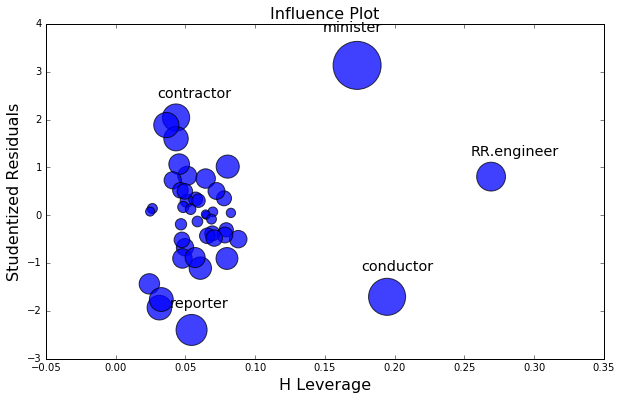

In [21]:
fig, ax = plt.subplots(figsize=(10,6))
fig = sm.graphics.influence_plot(prestige_model, ax=ax, criterion="cooks")

As you can see there are a few worrisome observations. Both contractor and reporter have low leverage but a large residual. 
RR.engineer has small residual and large leverage. Conductor and minister have both high leverage and large residuals, and, 
therefore, large influence.

__Partial Regression Plots__ are a principled way of looking at individual independent variables versus the dependent variable, for visualization.   

In a partial regression plot, to discern the relationship between the response variable and the $k$-th variable, we compute 
the residuals by regressing the response variable versus the independent variables excluding $X_k$. We can denote this by 
$X_{\sim k}$. We then compute the residuals by regressing $X_k$ on $X_{\sim k}$.     The partial regression plot is the plot 
of the former versus the latter residuals. 

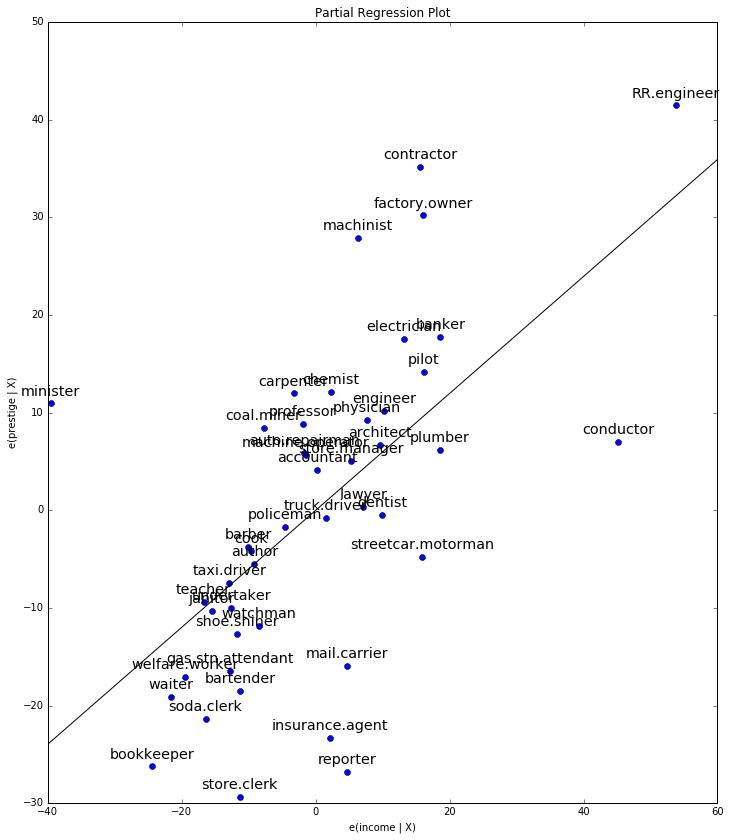

In [22]:

fix, ax = plt.subplots(figsize=(12,14))
fig = sm.graphics.plot_partregress("prestige", "income", ["education"], data=prestige, ax=ax)

As you can see the partial regression plot confirms the influence of conductor, minister, and RR.engineer on the partial relationship between income and prestige. The cases greatly decrease the effect of income on prestige. Dropping these cases confirms this.

In [23]:
subset = ~prestige.index.isin(["conductor", "RR.engineer", "minister"])
prestige_model2 = ols("prestige ~ income + education", data=prestige, subset=subset).fit()
print(prestige_model2.summary())

                            OLS Regression Results                            
Dep. Variable:               prestige   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     138.1
Date:                Tue, 14 Nov 2017   Prob (F-statistic):           2.02e-18
Time:                        10:52:38   Log-Likelihood:                -160.59
No. Observations:                  42   AIC:                             327.2
Df Residuals:                      39   BIC:                             332.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -6.3174      3.680     -1.717      0.0

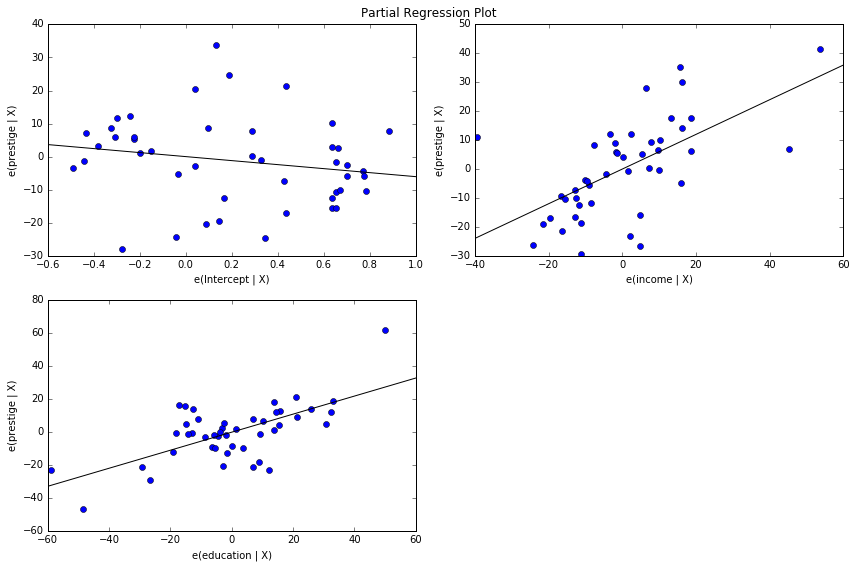

In [24]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_partregress_grid(prestige_model, fig=fig)